In [1]:
!pip3 install yahoo_fin
!pip3 install xgboost
!pip3 install lightgbm
!pip3 install pandas==1.0.5
!pip3 install numpy>=1.17
!pip3 install pystan --no-cache
!pip3 install prophet

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15:

In [1]:
# Raw Package
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot

#machine learning models
import xgboost as xgb
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#Data Source
from yahoo_fin import stock_info
import yfinance as yf

In [2]:
df = yf.download("AAPL", start="2021-01-01", end="2022-04-20") # interval='1m'

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,133.520004,133.610001,126.760002,129.410004,128.264984,143301900
2021-01-05,128.889999,131.740005,128.429993,131.009995,129.850815,97664900
2021-01-06,127.720001,131.050003,126.379997,126.599998,125.479843,155088000
2021-01-07,128.360001,131.630005,127.860001,130.919998,129.761612,109578200
2021-01-08,132.429993,132.630005,130.229996,132.050003,130.881638,105158200


#Interval data
interval='1m', minute level data is available for the latest 7 days period
interval='1h', hour level data is available for the latets 700 days period

In [4]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [100]:
len(prophet_train), len(prophet_val)

(248, 74)

[13:55:49] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[13:55:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:55:50] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[13:55:50] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:55:51] WARNING: ../src/objective/regression_

In [13]:
def mean_absolute_percentage_error(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true-y_pred)/y_true)*100

In [93]:
#Prophet
df_prophet= df.copy()
split_date = pd.to_datetime('2022-01-01')
prophet_train = df_prophet.loc[df_prophet.index<split_date].copy()
prophet_val = df_prophet.loc[df_prophet.index>split_date].copy()
prophet_train['ds'] = prophet_train.index
prophet_train['y'] = prophet_train['Close']
prophet_train.drop(['Close'], axis=1, inplace=True)

In [94]:
close_prices = prophet_val['Close'].to_list()
actual=[]
preds=[]
for i in range(0, len(close_prices)-1):
    preds.append(close_prices[i])
    actual.append(close_prices[i+1])

In [95]:
#simple naive model metrics
mape = mean_absolute_percentage_error(actual,preds)
mse = mean_squared_error(actual,preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual,preds)
print(f"MAPE: {mape} | RMSE: {rmse} | MAE: {mae}")

MAPE: 1.4882277691205805 | RMSE: 3.083584060196062 | MAE: 2.4919168132625216


In [96]:
#prophet model
m = Prophet(seasonality_mode='additive')
m.fit(prophet_train)
future = m.make_future_dataframe(periods=len(prophet_val), include_history=True)
forecast = m.predict(future)
prophet_preds = forecast['yhat'].to_list()[len(prophet_train):]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.98957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       749.987    0.00471813       250.278       0.861       0.861      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       752.233   0.000290156         188.2   1.848e-06       0.001      191  LS failed, Hessian reset 
     176       754.773   0.000109647        86.442    8.53e-07       0.001      308  LS failed, Hessian reset 
     192       755.229   7.53335e-05       66.1244   1.065e-06       0.001      370  LS failed, Hessian reset 
     199       755.284   0.000125213       56.7881      0.3272      0.3272      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       755.617   0.000191783       150.814   1.048e-06       0.001      461  LS failed, Hessian reset 
     299       756.201    0.00116673       75.1717        5.21   

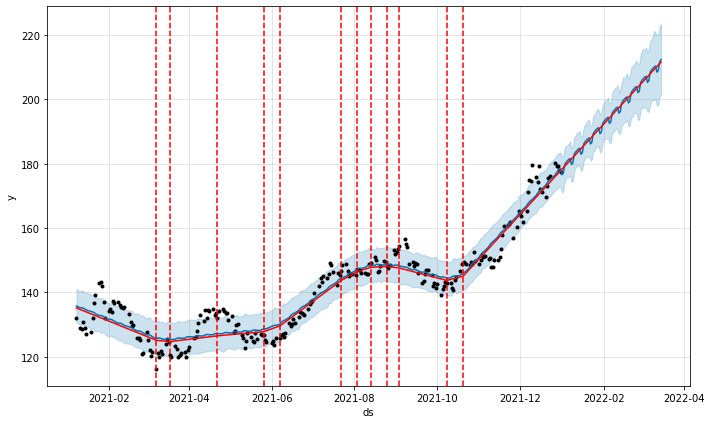

In [97]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

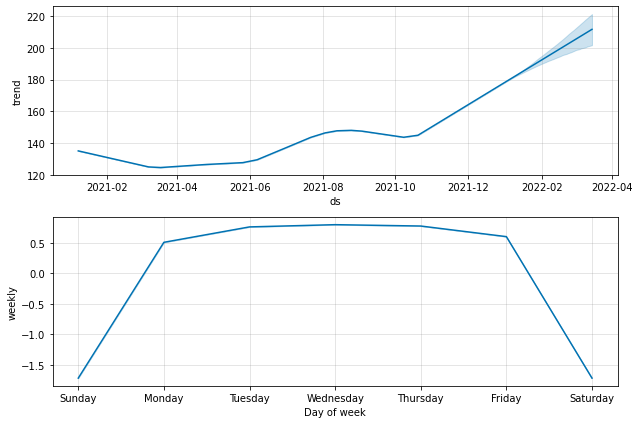

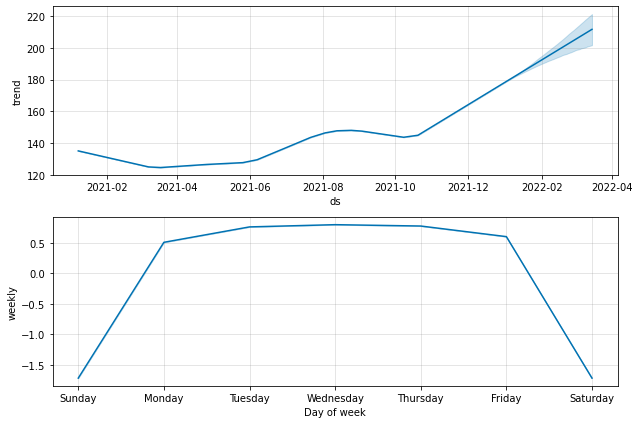

In [98]:
m.plot_components(forecast)

In [20]:
#model metrics
mape = mean_absolute_percentage_error(prophet_val['Close'], prophet_preds)
mse = mean_squared_error(prophet_val['Close'], prophet_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(prophet_val['Close'], prophet_preds)
print(f"MAPE: {mape} | RMSE: {rmse} | MAE: {mae}")

MAPE: 4.607050640769959 | RMSE: 9.425572246360746 | MAE: 7.455389164130209


In [21]:
#feature engineering
df['weekday'] = np.where(df.index.weekday > 5, 1, 0)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['close_price_lag1'] = df['Close'].shift(1)
df['close_price_lag2'] = df['Close'].shift(2)
df['close_price_lag3'] = df['Close'].shift(3)
df['close_price_lag4'] = df['Close'].shift(4)
df['open_price_lag1'] = df['Open'].shift(1)
df['open_price_lag2'] = df['Open'].shift(2)
df['open_price_lag3'] = df['Open'].shift(3)
df['open_price_lag4'] = df['Open'].shift(4)
df['high_price_lag1'] = df['High'].shift(1)
df['low_price_lag1'] = df['Low'].shift(1)
df['close_price_error_percent'] = df['Close'].pct_change()
df['open_price_error_percent'] = df['Open'].pct_change()
df['high_price_error_percent'] = df['High'].pct_change()
df['low_price_error_percent'] = df['Low'].pct_change()
df['adj_close_price_error_percent'] = df['Adj Close'].pct_change()

In [22]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,weekday,year,month,day,...,open_price_lag2,open_price_lag3,open_price_lag4,high_price_lag1,low_price_lag1,close_price_error_percent,open_price_error_percent,high_price_error_percent,low_price_error_percent,adj_close_price_error_percent
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,133.520004,133.610001,126.760002,129.410004,128.264984,143301900,0,2021,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,128.889999,131.740005,128.429993,131.009995,129.850815,97664900,0,2021,1,5,...,NaN,NaN,NaN,133.610001,126.760002,0.012364,-0.034676,-0.013996,0.013174,0.012364
2021-01-06,127.720001,131.050003,126.379997,126.599998,125.479843,155088000,0,2021,1,6,...,133.520004,NaN,NaN,131.740005,128.429993,-0.033662,-0.009077,-0.005238,-0.015962,-0.033661
2021-01-07,128.360001,131.630005,127.860001,130.919998,129.761612,109578200,0,2021,1,7,...,128.889999,133.520004,NaN,131.050003,126.379997,0.034123,0.005011,0.004426,0.011711,0.034123
2021-01-08,132.429993,132.630005,130.229996,132.050003,130.881638,105158200,0,2021,1,8,...,127.720001,128.889999,133.520004,131.630005,127.860001,0.008631,0.031708,0.007597,0.018536,0.008631


<AxesSubplot:xlabel='Date'>

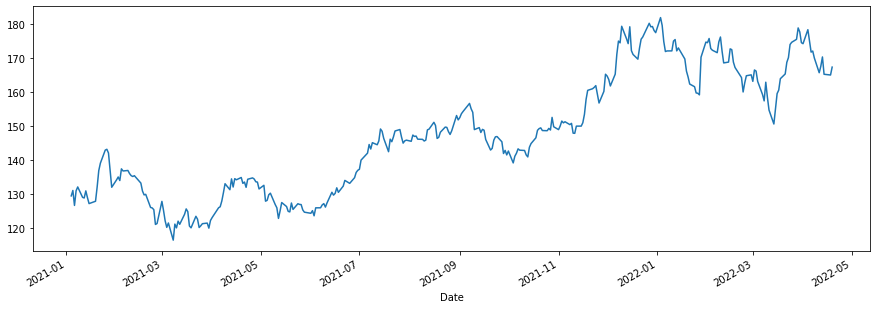

In [23]:
df['Close'].plot(figsize=(15,5))

/home/hari/.local/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/hari/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


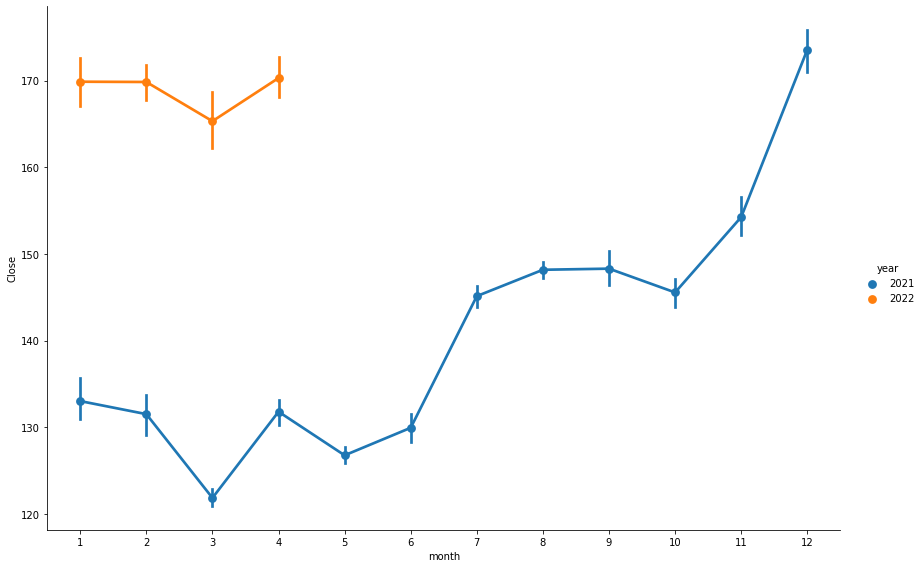

In [24]:
plt = sns.factorplot('month','Close',hue='year',data=df,height=8,aspect=1.5,legend=True)
plt.tight_layout()

In [25]:
df = df.dropna()
df_sorted = df.sort_values(by='Date', ascending=False)

In [67]:
df_sorted.head()

,Open,High,Low,Close,Adj Close,Volume,weekday,year,month,day,...,open_price_lag2,open_price_lag3,open_price_lag4,high_price_lag1,low_price_lag1,close_price_error_percent,open_price_error_percent,high_price_error_percent,low_price_error_percent,adj_close_price_error_percent
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-19,165.020004,167.820007,163.910004,167.399994,167.154404,67723800,0,2022,4,19,...,170.619995,167.389999,168.020004,166.600006,163.570007,0.014115,0.006711,0.007323,0.002079,0.014115
2022-04-18,163.919998,166.600006,163.570007,165.070007,164.827835,69023900,0,2022,4,18,...,167.389999,168.020004,168.710007,171.270004,165.039993,-0.001331,-0.039269,-0.027267,-0.008907,-0.001331
2022-04-14,170.619995,171.270004,165.039993,165.289993,165.047501,75329400,0,2022,4,14,...,168.020004,168.710007,171.779999,171.039993,166.770004,-0.029988,0.019296,0.001345,-0.010374,-0.029988
2022-04-13,167.389999,171.039993,166.770004,170.399994,170.149994,70618900,0,2022,4,13,...,168.710007,171.779999,171.160004,169.869995,166.639999,0.016343,-0.003750,0.006888,0.000780,0.016342
2022-04-12,168.020004,169.869995,166.639999,167.660004,167.414032,79265200,0,2022,4,12,...,171.779999,171.160004,172.360001,169.029999,165.500000,0.011523,-0.004090,0.004970,0.006888,0.011523


In [74]:
#split data into train and test parts
split_date = pd.to_datetime('2022-01-01')
train = df_sorted[df_sorted.index<split_date].copy()
val = df_sorted[df_sorted.index>split_date].copy()

In [75]:
X_train = train.drop(['Close'], axis=1)
Y_train = train['Close']
X_val = val.drop(['Close'], axis=1)
Y_val = val['Close']

In [76]:
X_train.head()

,Open,High,Low,Adj Close,Volume,weekday,year,month,day,close_price_lag1,...,open_price_lag2,open_price_lag3,open_price_lag4,high_price_lag1,low_price_lag1,close_price_error_percent,open_price_error_percent,high_price_error_percent,low_price_error_percent,adj_close_price_error_percent
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,178.089996,179.229996,177.259995,177.083878,64062300,0,2021,12,31,178.199997,...,179.330002,180.160004,177.089996,180.570007,178.089996,-0.003535,-0.007689,-0.007421,-0.004661,-0.003535
2021-12-30,179.470001,180.570007,178.089996,177.712143,59773000,0,2021,12,30,179.380005,...,180.160004,177.089996,175.850006,180.630005,178.139999,-0.006578,0.000781,-0.000332,-0.000281,-0.006578
2021-12-29,179.330002,180.630005,178.139999,178.888916,62348900,0,2021,12,29,179.289993,...,177.089996,175.850006,173.039993,181.330002,178.529999,0.000502,-0.004607,-0.003860,-0.002185,0.000502
2021-12-28,180.160004,181.330002,178.529999,178.799149,79144300,0,2021,12,28,180.330002,...,175.850006,173.039993,171.559998,180.419998,177.070007,-0.005767,0.017336,0.005044,0.008245,-0.005767
2021-12-27,177.089996,180.419998,177.070007,179.836319,74919600,0,2021,12,27,176.279999,...,173.039993,171.559998,168.279999,176.850006,175.270004,0.022975,0.007051,0.020187,0.010270,0.022975


In [77]:
#decision tree
dt_model = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')
dt_model.fit(X_train, Y_train)

DecisionTreeRegressor(random_state=0)

<AxesSubplot:xlabel='Date'>

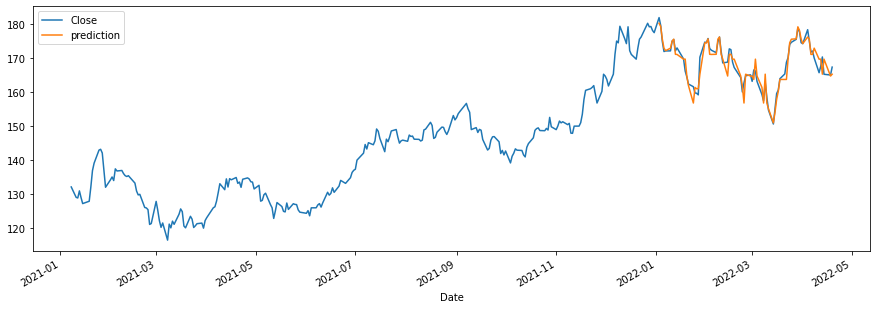

In [78]:
val['prediction'] = dt_model.predict(X_val)
preds = pd.concat([val,train], sort=False)
preds[['Close', 'prediction']].plot(figsize=(15,5))

In [79]:
#model metrics
mape = mean_absolute_percentage_error(Y_val,val['prediction'])
mse = mean_squared_error(Y_val,val['prediction'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_val,val['prediction'])
print(f"MAPE: {mape} | RMSE: {rmse} | MAE: {mae}")

MAPE: 0.8800464701035793 | RMSE: 2.0550412491187147 | MAE: 1.4700010145032727


In [101]:
#random forest
rf_model = RandomForestRegressor(n_estimators=100,
                max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None,
                random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
rf_model.fit(X_train, Y_train)

RandomForestRegressor()

<AxesSubplot:xlabel='Date'>

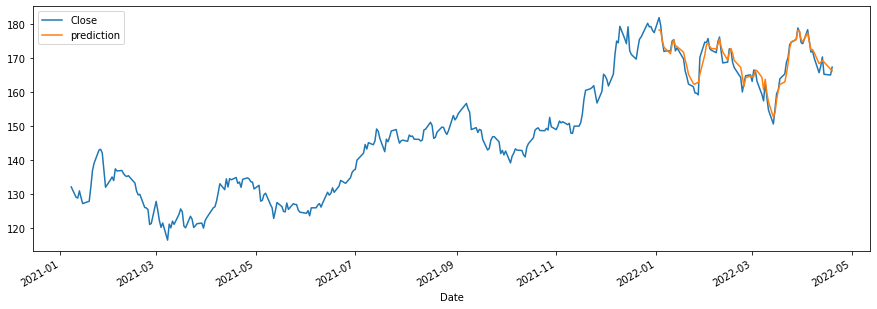

In [102]:
val['prediction'] = rf_model.predict(X_val)
preds = pd.concat([val,train], sort=False)
preds[['Close', 'prediction']].plot(figsize=(15,5))

In [104]:
#model metrics
mape = mean_absolute_percentage_error(Y_val,val['prediction'])
mse = mean_squared_error(Y_val,val['prediction'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_val,val['prediction'])
print(f"MAPE: {mape} | RMSE: {rmse} | MAE: {mae}")

MAPE: 0.9781353651911215 | RMSE: 2.049243416573398 | MAE: 1.626144112251899


In [105]:
#xgboost model
xgb_model = xgb.XGBRegressor(n_estimators=100, tree_method="hist",
            eval_metric=mean_absolute_error)
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x7fe7fa0b1dc0>,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='hist',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

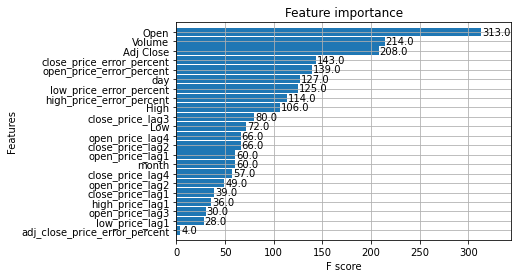

In [106]:
plot_importance(xgb_model, height=0.9)

<AxesSubplot:xlabel='Date'>

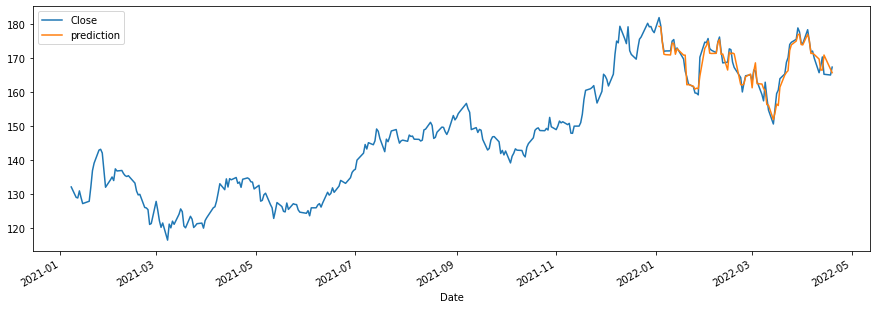

In [107]:
val['prediction'] = xgb_model.predict(X_val)
preds = pd.concat([val,train], sort=False)
preds[['Close', 'prediction']].plot(figsize=(15,5))

In [108]:
#model metrics
mape = mean_absolute_percentage_error(Y_val,val['prediction'])
mse = mean_squared_error(Y_val,val['prediction'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_val,val['prediction'])
print(f"MAPE: {mape} | RMSE: {rmse} | MAE: {mae}")

MAPE: 0.978109018462054 | RMSE: 2.10305736949356 | MAE: 1.6321101833034206


In [109]:
# A parameter grid for XGBoost
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

In [110]:
xgb_model = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgb_model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)
xgb_grid.fit(X_train, Y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:    3.9s finished


[14:08:55] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:08:55] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    val

<AxesSubplot:xlabel='Date'>

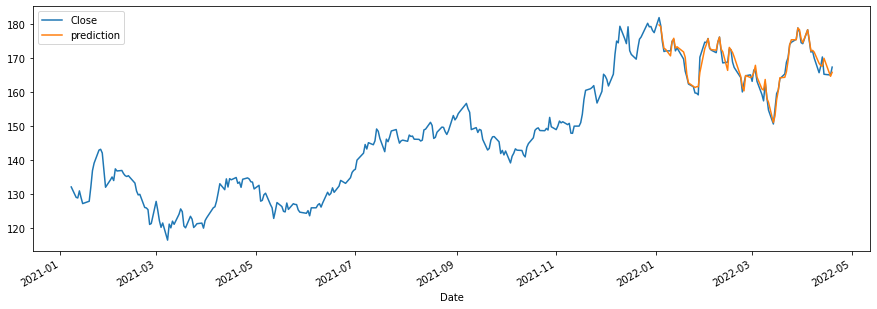

In [111]:
val['prediction'] = xgb_grid.predict(X_val)
preds = pd.concat([val,train], sort=False)
preds[['Close', 'prediction']].plot(figsize=(15,5))

In [112]:
#model metrics
mape = mean_absolute_percentage_error(Y_val,val['prediction'])
mse = mean_squared_error(Y_val,val['prediction'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_val,val['prediction'])
print(f"MAPE: {mape} | RMSE: {rmse} | MAE: {mae}")

MAPE: 0.7191135091032573 | RMSE: 1.6516329489371582 | MAE: 1.1965979498785895


In [113]:
#lgb model
lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=-1, 
                learning_rate=0.1, n_estimators=10, subsample_for_bin=200000,
                objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001,
                min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0,
                reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
lgb_model.fit(X_train, Y_train)

LGBMRegressor(n_estimators=10)

<AxesSubplot:xlabel='Date'>

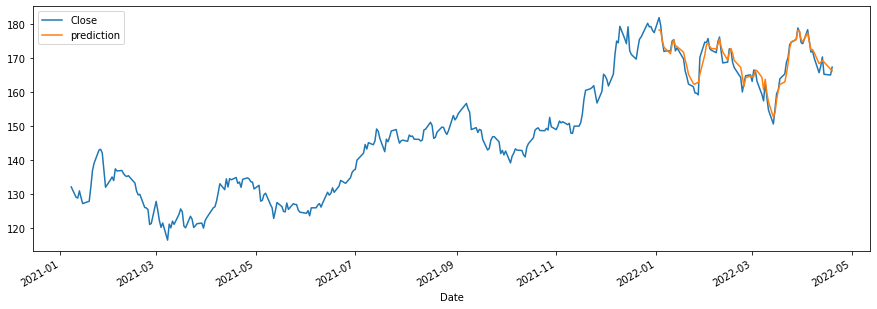

In [114]:
val['prediction'] = rf_model.predict(X_val)
preds = pd.concat([val,train], sort=False)
preds[['Close', 'prediction']].plot(figsize=(15,5))

In [115]:
#model metrics
mape = mean_absolute_percentage_error(Y_val,val['prediction'])
mse = mean_squared_error(Y_val,val['prediction'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_val,val['prediction'])
print(f"MAPE: {mape} | RMSE: {rmse} | MAE: {mae}")

MAPE: 0.9781353651911215 | RMSE: 2.049243416573398 | MAE: 1.626144112251899
[14:08:52] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:08:52] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:08:52] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:08:52] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if